In [16]:
import numpy as np
from keras.datasets import mnist
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Flatten
from sklearn.linear_model import LogisticRegression

import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

# Convolutional Neural Networks
A Convolutional Neural Network (CNN) is a type of constrained neural network, and neural networks are extensions of logistic regression in a sense. The idea is that a linear function is too weak to capture the complexities of the data, so we should use some sort of nonlinear function. This can be done by taking $u = g(W_2 g(W_1x))$, for example, which would be a two-layer neural network. If $g$ is a nonlinear function, then $u$ can be a nonlinear function of $x$. In addition, if $g$ is differentiable most places, then we can use the chain rule to find $\frac{du}{dW_1}$ and $\frac{du}{dW_2}$. We can also compute $\frac{dL}{du}$ by the chain rule, so then we have $\frac{dL}{dW_1} = \frac{dL}{du} \frac{du}{dW_1}$ by the chain rule (up to a transpose maybe), so we can perform gradient descent here. Although this is a nonconvex function, in practice, gradient descent with a momentum term tends to be fairly effective, and $g$ is often taken to be something like $g(x)=\max(0, x)$, which is a.e. differentiable.

A convolutional neural network takes this a step further, constraining these $W$ to be convolutions. Convolutions are linear functions, so they can be represented in this form, but they require fewer parameters than other methods, as weights can be shared across the whole image, with each filter serving as a global detector of a pattern. The model I chose can be viewed below, but essentially there are several sets of convolutions, and to decrease the dimensionality of the outputs, I use strided convolutions. This model has about 1.25 million learnable parameters, which is much more than logistic regression's $785\cdot 10 = 7850$ parameters, and also is an indicator that the model probably has the capacity to overfit. In general, it is desirable to have models with fewer parameters.

After a few epochs of training, this reaches about 98-99 percent test accuracy, which is significantly better than logistic regression. State of the art classifiers on MNIST typically achieve about 99.5% accuracy, which could be an indication that they achieve the bayes error rate (or thereabouts).

In [10]:
(x_train, y_train_orig), (x_test, y_test_orig) = mnist.load_data()
x_train = x_train[..., None] / 255.0
x_test = x_test[..., None] / 255.0
y_train = keras.utils.to_categorical(y_train_orig)
y_test = keras.utils.to_categorical(y_test_orig)

In [3]:
np.random.seed(1151998)
model = keras.models.Sequential()
model.add(Conv2D(32, (3,3), padding='same', input_shape=(28, 28, 1), activation='relu'))
model.add(Conv2D(64, (3,3), strides=(2,2), padding='same', activation='relu'))
model.add(Conv2D(32, (3,3), strides=(2,2), padding='same', activation='relu'))
model.add(Flatten())
model.add(Dense(768, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(keras.optimizers.Adam(), keras.losses.categorical_crossentropy,
             metrics=['accuracy'])

In [24]:
print('%d learnable parameters'%model.count_params())

1249962 learnable parameters


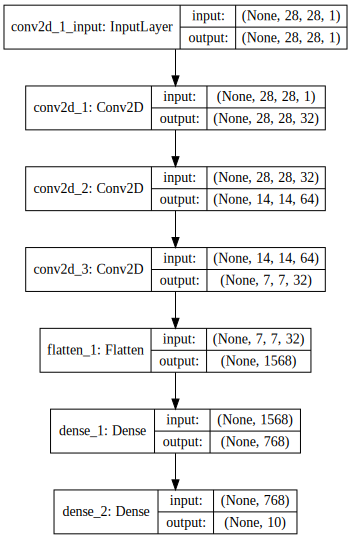

In [23]:
SVG(model_to_dot(model, show_shapes=True, rankdir='TB').create(prog='dot', format='svg'))

In [6]:
np.random.seed(1151998)
model.fit(x_train, y_train, validation_split=0.15, epochs=2)

In [7]:
model.load_weights('./simple_cnn.h5')

In [8]:
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 3s 299us/step


[0.05835601056503074, 0.982]

In [12]:
pred_y = model.predict(x_test)

Text(0.5,1,'Confusion Matrix')

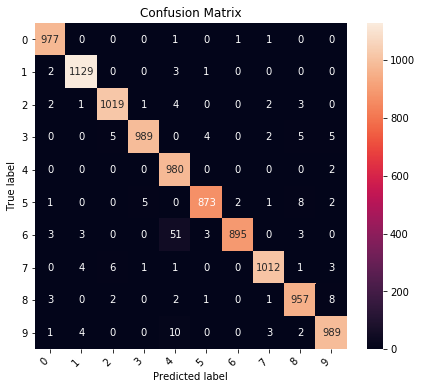

In [13]:
conf_mat = metrics.confusion_matrix(y_test_orig, pred_y.argmax(1))
class_names = list(range(10))
df_cm = pd.DataFrame(
    conf_mat, index=class_names, columns=class_names, 
)
fig = plt.figure(figsize=(7, 6))
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')